# Properties of ELGs in DR7 Imaging

The purpose of this notebook is to quantify the observed properties (particulary size and ellipticity) of ELGs using DR7 catalogs of the COSMOS region.  We use the HST/ACS imaging of objects in this region as "truth."

J. Moustakas  
2018 Aug 15

In [1]:
import os, warnings, pdb
import numpy as np
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
rc = {'font.family': 'serif'}#, 'text.usetex': True}
sns.set(style='ticks', font_scale=1.5, palette='Set2', rc=rc)

In [3]:
%matplotlib inline

#### Read the HST/ACS parent (truth) catalog.

In [4]:
acsfile = os.path.join(os.getenv('DESI_ROOT'), 'target', 'analysis', 'truth', 'parent', 'cosmos-acs.fits.gz')
allacs = Table(fitsio.read(acsfile, ext=1, upper=True))
print('Read {} objects from {}'.format(len(allacs), acsfile))

Read 1177274 objects from /global/project/projectdirs/desi/target/analysis/truth/parent/cosmos-acs.fits.gz


#### Assemble all the functions we'll need.

In [5]:
def read_tractor(subset='0'):
    """Read the Tractor catalogs for a given cosmos subsest and cross-match 
    with the ACS catalog.
    
    """
    from glob import glob
    from astropy.table import vstack
    from astrometry.libkd.spherematch import match_radec    
    
    tractordir = '/global/cscratch1/sd/dstn/cosmos-dr7-7{}/tractor'.format(subset)
    tractorfiles = glob('{}/???/tractor-*.fits'.format(tractordir))
    
    alldr7 = []
    for ii, tractorfile in enumerate(tractorfiles):
        #if (ii % 10) == 0:
        #    print('Read {:02d} / {:02d} Tractor catalogs from subset {}.'.format(ii, len(tractorfiles), subset))
        alldr7.append(Table(fitsio.read(tractorfile, ext=1, upper=True)))
    alldr7 = vstack(alldr7)
    alldr7 = alldr7[alldr7['BRICK_PRIMARY']]
    
    # Cross-match
    m1, m2, d12 = match_radec(allacs['RA'], allacs['DEC'], alldr7['RA'], 
                              alldr7['DEC'], 1./3600.0, nearest=True)
    print('Read {} objects with HST/ACS and DR7 photometry'.format(len(m1)))
    
    return allacs[m1], alldr7[m2]

In [6]:
def select_ELGs(acs, dr7):
    from desitarget.cuts import isELG_south
    
    def unextinct_fluxes(cat):
        """We need to unextinct the fluxes ourselves rather than using desitarget.cuts.unextinct_fluxes
        because the Tractor catalogs don't have forced WISE photometry.
        
        """
        res = np.zeros(len(cat), dtype=[('GFLUX', 'f4'), ('RFLUX', 'f4'), ('ZFLUX', 'f4')])
        for band in ('G', 'R', 'Z'):
            res['{}FLUX'.format(band)] = ( cat['FLUX_{}'.format(band)] / 
                                           cat['MW_TRANSMISSION_{}'.format(band)] )
        return Table(res)
        
    fluxes = unextinct_fluxes(dr7)
    gflux, rflux, zflux = fluxes['GFLUX'], fluxes['RFLUX'], fluxes['ZFLUX']
    ielg = isELG_south(gflux=fluxes['GFLUX'], rflux=fluxes['RFLUX'], 
                       zflux=fluxes['ZFLUX'])#, gallmask=alltarg['ALLMASK_G'],
                       #rallmask=alltarg['ALLMASK_R'], zallmask=alltarg['ALLMASK_Z'])
    print('Selected {} / {} ELGs'.format(np.sum(ielg), len(acs)))
    return acs[ielg], dr7[ielg]

In [7]:
def get_mag(cat, band='R'):
    return 22.5 - 2.5 * np.log10(cat['FLUX_{}'.format(band)])

def get_reff_acs(cat):
    """Convert SExtractor's flux_radius to half-light radius 
    using the relation (derived from simulations) in Sec 4.2 
    of Griffith et al. 2012.
    """
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        reff = np.log10(0.03 * 0.162 * cat['FLUX_RADIUS']**1.87)
    return reff

def get_reff_tractor(cat):
    fracdev = cat['FRACDEV']
    reff = np.log10(fracdev * cat['SHAPEDEV_R'] + (1 - fracdev) * cat['SHAPEEXP_R'])
    return reff   

def get_ell_acs(cat):
    ell = 1 - cat['B_IMAGE'] / cat['A_IMAGE']
    return ell

def get_ell_tractor(cat):
    fracdev = cat['FRACDEV']
    ell_exp = np.hypot(cat['SHAPEEXP_E1'], cat['SHAPEEXP_E2'])
    ell_dev = np.hypot(cat['SHAPEDEV_E1'], cat['SHAPEDEV_E2'])
    ell = fracdev * ell_dev + (1 - fracdev) * ell_exp
    return ell

In [23]:
def qa_true_properties(acs, dr7, subsetlabel='0', noplots=False, 
                       pngsize=None, pngellipticity=None):
    """Use HST to characterize the *true* ELG size and ellipticity 
    distributions.
    
    """
    istar = acs['CLASS_STAR'] > 0.9
    igal = ~istar
    nstar, ngal, nobj = np.sum(istar), np.sum(igal), len(acs)
    
    print('True galaxies, N={} ({:.2f}%):'.format(ngal, 100*ngal/nobj))
    for tt in ('PSF ', 'REX ', 'EXP ', 'DEV ', 'COMP'):
        nn = np.sum(dr7['TYPE'][igal] == tt)
        frac = 100 * nn / ngal
        print('  {}: {} ({:.2f}%)'.format(tt, nn, frac))

    print('True stars, N={} ({:.2f}%):'.format(nstar, 100*nstar/nobj))
    for tt in ('PSF ', 'REX ', 'EXP ', 'DEV ', 'COMP'):
        nn = np.sum(dr7['TYPE'][istar] == tt)
        frac = 100 * nn / nstar
        print('  {}: {} ({:.2f}%)'.format(tt, nn, frac))
    
    if noplots:
        return
    
    rmag = get_mag(dr7)
    reff = get_reff_acs(acs)
    ell = get_ell_acs(acs)
    
    # Size
    j = sns.jointplot(rmag[igal], reff[igal], kind='hex', space=0, alpha=0.7,
                      stat_func=None, cmap='viridis', mincnt=3)
    j.set_axis_labels('DECaLS $r$ (AB mag)', r'$\log_{10}$ (HST/ACS Half-light radius) (arcsec)')
    j.fig.set_figwidth(10)
    j.fig.set_figheight(7)
    j.ax_joint.axhline(y=np.log10(0.45), color='k', ls='--')
    j.ax_joint.scatter(rmag[istar], reff[istar], marker='s', color='orange', s=10)
    j.ax_joint.text(20.8, np.log10(0.45)+0.1, r'$r_{eff}=0.45$ arcsec', ha='left', va='center', 
                    fontsize=14)
    j.ax_joint.text(0.15, 0.2, 'HST Stars', ha='left', va='center', 
                    fontsize=14, transform=j.ax_joint.transAxes)
    j.ax_joint.text(0.05, 0.9, '{}'.format(subsetlabel), ha='left', va='center', 
                    fontsize=16, transform=j.ax_joint.transAxes)
    if pngsize:
        plt.savefig(pngsize)
        
    # Ellipticity
    j = sns.jointplot(rmag[igal], ell[igal], kind='hex', space=0, alpha=0.7,
                      stat_func=None, cmap='viridis', mincnt=3)
    j.set_axis_labels('DECaLS $r$ (AB mag)', 'HST/ACS Ellipticity')
    j.fig.set_figwidth(10)
    j.fig.set_figheight(7)
    j.ax_joint.scatter(rmag[istar], ell[istar], marker='s', color='orange', s=10)
    j.ax_joint.text(0.15, 0.2, 'HST Stars', ha='left', va='center', 
                    fontsize=14, transform=j.ax_joint.transAxes)
    j.ax_joint.text(0.05, 0.9, '{}'.format(subsetlabel), ha='left', va='center', 
                    fontsize=16, transform=j.ax_joint.transAxes)
    if pngellipticity:
        plt.savefig(pngellipticity)        

In [9]:
def qa_compare_radii(acs, dr7, subsetlabel='0', seeing=None, png=None):
    """Compare the HST and Tractor sizes."""
    igal = dr7['TYPE'] != 'PSF '
    
    reff_acs = get_reff_acs(acs[igal])
    reff_tractor = get_reff_tractor(dr7[igal])
    sizelim = (-1.5, 1)
    
    j = sns.jointplot(reff_acs, reff_tractor, kind='hex', space=0, alpha=0.7,
                      stat_func=None, cmap='viridis', mincnt=3,
                      xlim=sizelim, ylim=sizelim)
    j.set_axis_labels(r'$\log_{10}$ (HST/ACS Half-light radius) (arcsec)', 
                      r'$\log_{10}$ (Tractor/DR7 Half-light radius) (arcsec)')
    j.fig.set_figwidth(10)
    j.fig.set_figheight(7)
    j.ax_joint.plot([-2, 2], [-2, 2], color='k')    
    if seeing:
        j.ax_joint.axhline(y=np.log10(seeing), ls='--', color='k')
    j.ax_joint.text(0.05, 0.9, '{}'.format(subsetlabel), ha='left', va='center', 
                    fontsize=16, transform=j.ax_joint.transAxes)
    if png:
        plt.savefig(png)

### Use subset 0 to characterize the "true" ELG properties.

Read 40339 objects with HST/ACS and DR7 photometry
Selected 3057 / 40339 ELGs
True galaxies, N=2955 (96.66%):
  PSF : 180 (6.09%)
  REX : 2492 (84.33%)
  EXP : 233 (7.88%)
  DEV : 49 (1.66%)
  COMP: 1 (0.03%)
True stars, N=102 (3.34%):
  PSF : 75 (73.53%)
  REX : 22 (21.57%)
  EXP : 3 (2.94%)
  DEV : 2 (1.96%)
  COMP: 0 (0.00%)


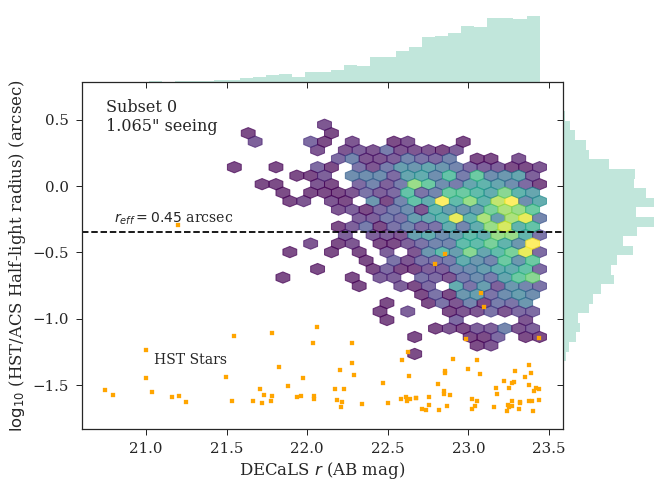

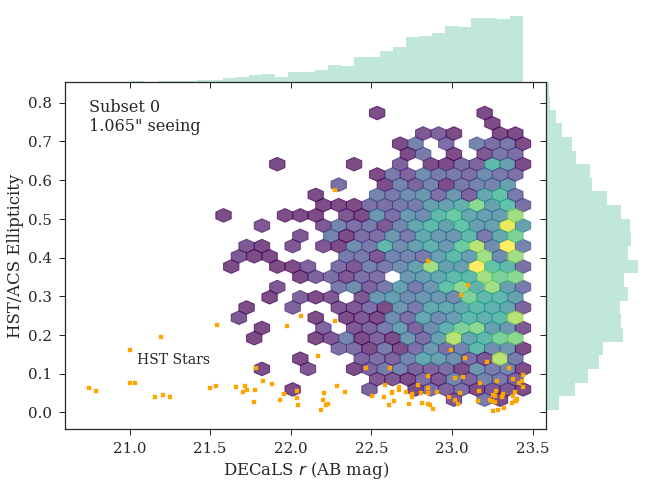

In [21]:
subset = '0'
allacs, alldr7 = read_tractor(subset=subset)
acs, dr7 = select_ELGs(allacs, alldr7)
subsetlabel = 'Subset {}\n{:.3f}" seeing'.format(subset, np.median(alldr7['PSFSIZE_R']))
qa_true_properties(acs, dr7, subsetlabel=subsetlabel, pngsize='truesize.png', pngellipticity='trueell.png')

### Compare radii measured in three subsets of increasingly poor seeing (but same nominal depth).

Read 40339 objects with HST/ACS and DR7 photometry
Selected 3057 / 40339 ELGs
Read 40339 objects with HST/ACS and DR7 photometry
Selected 3150 / 40339 ELGs
Read 40339 objects with HST/ACS and DR7 photometry
Selected 3282 / 40339 ELGs


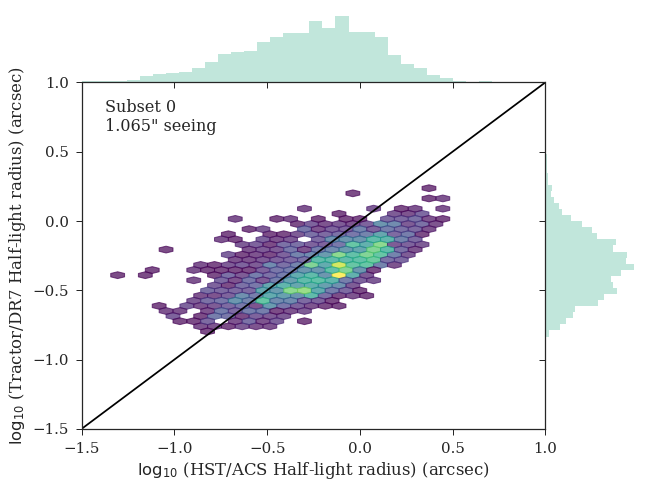

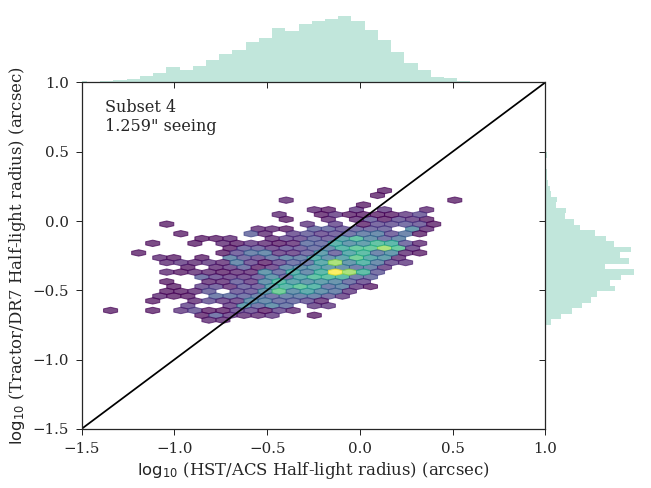

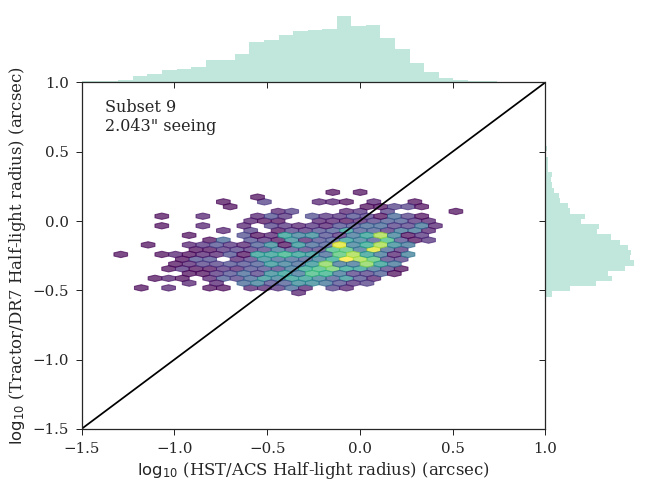

In [14]:
for subset in ('0', '4', '9'):
    allacs, alldr7 = read_tractor(subset=subset)
    acs, dr7 = select_ELGs(allacs, alldr7)
    medseeing = np.median(alldr7['PSFSIZE_R'])
    subsetlabel = 'Subset {}\n{:.3f}" seeing'.format(subset, medseeing)
    qa_compare_radii(acs, dr7, subsetlabel=subsetlabel, png='size_compare_subset{}.png'.format(subset))

In [24]:
subset = '9'
allacs, alldr7 = read_tractor(subset=subset)
acs, dr7 = select_ELGs(allacs, alldr7)
subsetlabel = 'Subset {}\n{:.3f}" seeing'.format(subset, np.median(alldr7['PSFSIZE_R']))
qa_true_properties(acs, dr7, subsetlabel=subsetlabel, noplots=True)

Read 40339 objects with HST/ACS and DR7 photometry
Selected 3282 / 40339 ELGs
True galaxies, N=3146 (95.86%):
  PSF : 758 (24.09%)
  REX : 2225 (70.72%)
  EXP : 120 (3.81%)
  DEV : 43 (1.37%)
  COMP: 0 (0.00%)
True stars, N=136 (4.14%):
  PSF : 99 (72.79%)
  REX : 31 (22.79%)
  EXP : 3 (2.21%)
  DEV : 3 (2.21%)
  COMP: 0 (0.00%)
